<a href="https://colab.research.google.com/github/portoforigin/deeplearn/blob/main/fastai/PETS_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Install Dependencies:**

 - Default version of fastai in Google Colab is 1.0.61(?), we need >v2.2.5

In [ ]:
!pip install -Uqq fastai
!pip install lime

import fastai
fastai.__version__

PROJECT_NAME = "FastAI_PETS"
MODEL_NAME = "fastai_pets_breed_001.pkl"

## **Data Loader Notes**
**DataLoader Input Args:**
- valid_pct: Percentage of data set put aside for validation

**DataBlock API**



**Learner Args (cnn_learner):**
- metrics:
  - **error_rate**: what percentage is being incorrectly labeled incorrectly
  - **accuracy**: (1.0 - error_rate)

**Learner Output (loss):**
- **Loss function**
 - Closely related to error_rate, shows changes in model
 - error_rate / accuracy may not be sensitive enough to be detect model changes

**Overfitting**
- Loss functions should decrease between epochs
- Training loss will keep going down
- Validation loss will start to increase

**Transfer Learning**
- Use a pre-trained model for a task different to what it was originally trained for


## **PETS Dataset**

Load the PETS dataset:

In [ ]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

files = get_image_files(path/"images")
print("There are %s images" % (len(files)))


There are 7390 images


**ImageDataLoader Label: Cat vs. Dogs**
 - Labeling function: first letter uppercase == cat
 - ImageDataLoader is a wrapper around DataBlocks (recommended just use DataBlocks for loading data)

**WTF: Why do some images show black when using ImageDataLoader**

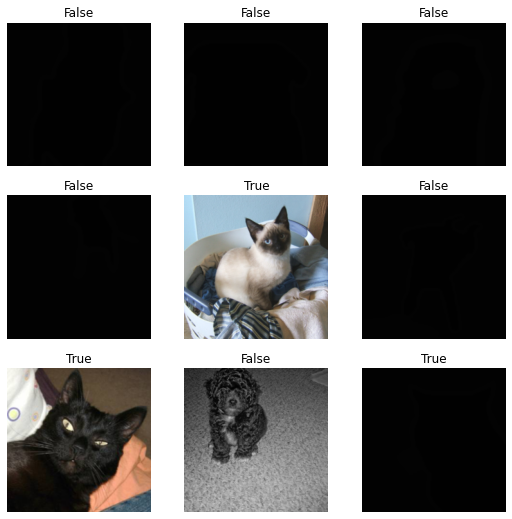

In [ ]:
# Label Function
# - Capital first letter indicates Cat
def label_func(f): return f[0].isupper()

# Load Data set
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=label_func, item_tfms=Resize(224),
    metrics=error_rate)

dls.show_batch()

## **DataBlock Example**
Load PETS dataset and label Cat: True Dog: False

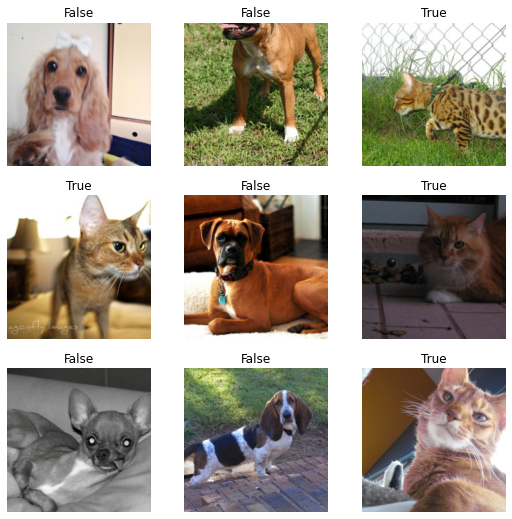

In [ ]:
# Label Function
# - Capital first letter indicates Cat
# - Label Function is provided a Posix Path Filename
def label_func(f):return f.name[0].isupper()

pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=label_func,
                 item_tfms=Resize(224)
                 )
dls = pets.dataloaders(path/"images")

dls.show_batch()

Slightly more interesting label based on breed

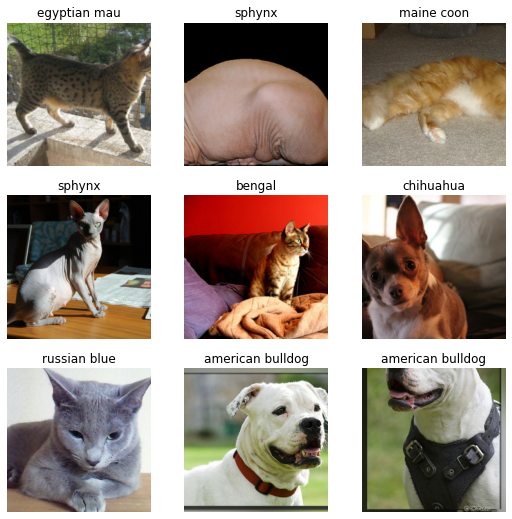

In [ ]:
# Label Function
# - Label based on breed from filename
# - Label Function is provided a Posix Path Filename
def label_func(f):
  breed = " ".join(f.name.split("_")[0:-1]).lower()
  return breed

pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=label_func,
                 item_tfms=Resize(224)
                 )
dls = pets.dataloaders(path/"images")

dls.show_batch()

Repeat using Regex instead of Label Function

In [ ]:
# Use Regex to Parse filename
# Grab the first file for test
fname = (path/"images").ls()[0]
re.findall(r'(.+)_\d+.jpg$', fname.name)

['english_cocker_spaniel']

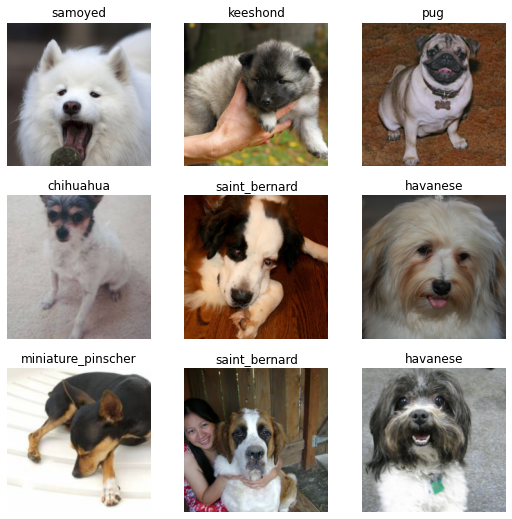

In [ ]:
# Label is parsed from file name
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(224),
                 #batch_tfms=aug_transforms(size=224, min_scale=0.75)
                 )
dls = pets.dataloaders(path/"images")

dls.show_batch()

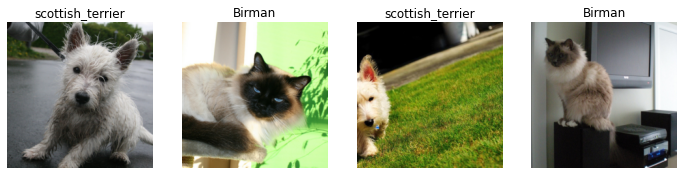

In [ ]:
dls.train.show_batch(max_n=4, nrows=1)

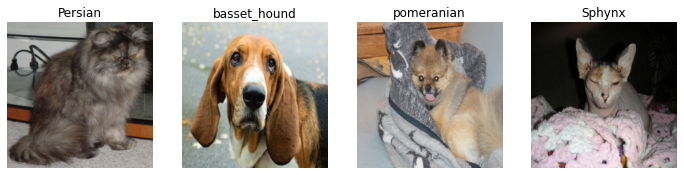

In [ ]:
# Squish image
pets = pets.new(item_tfms=Resize(224, ResizeMethod.Squish))
dls_squish = pets.dataloaders(path/"images")
dls_squish.train.show_batch(max_n=4, nrows=1)

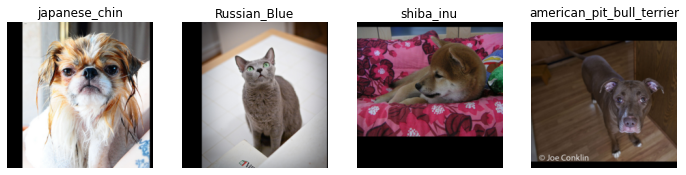

In [ ]:
# Padding Image
pets = pets.new(item_tfms=Resize(224, ResizeMethod.Pad, pad_mode='zeros'))
dls_pad = pets.dataloaders(path/"images")
dls_pad.train.show_batch(max_n=4, nrows=1)

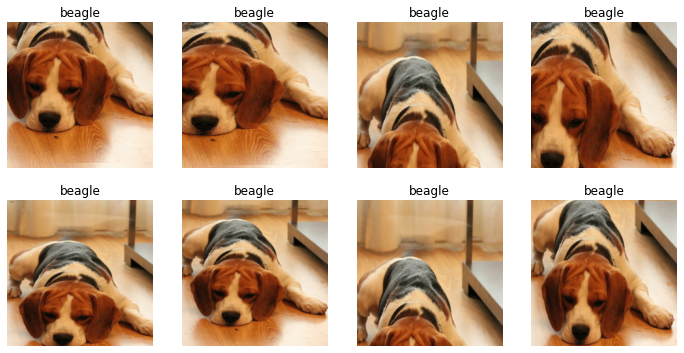

In [ ]:
# Random Resize Crop Image
pets = pets.new(item_tfms=RandomResizedCrop(224, min_scale=0.3))
dls_crop = pets.dataloaders(path/"images")
dls_crop.train.show_batch(max_n=8, nrows=2, unique=True)

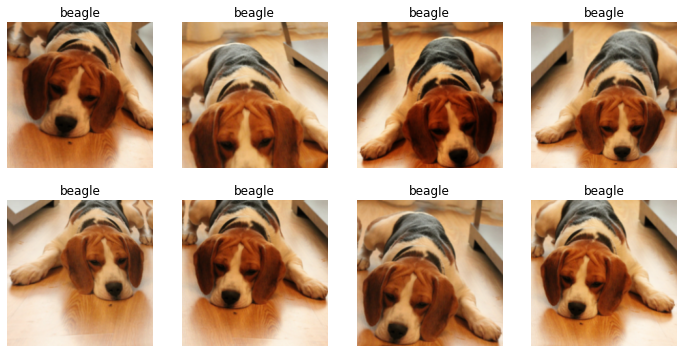

In [ ]:
# Resize / Batch Augmentation Transfrom
#pets = pets.new(item_tfms=Resize(224), batch_tfms=aug_transforms(mult=2))
pets = pets.new(item_tfms=Resize(224), batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls_batch = pets.dataloaders(path/"images")
dls_batch.train.show_batch(max_n=8, nrows=2, unique=True)

## **Let's Build a Model**


In [ ]:
learn = cnn_learner(dls_batch, resnet34, metrics=error_rate)
learn.fine_tune(1)


epoch,train_loss,valid_loss,error_rate,time
0,1.576151,0.370031,0.123139,00:49


epoch,train_loss,valid_loss,error_rate,time
0,0.530630,0.292692,0.093369,00:52


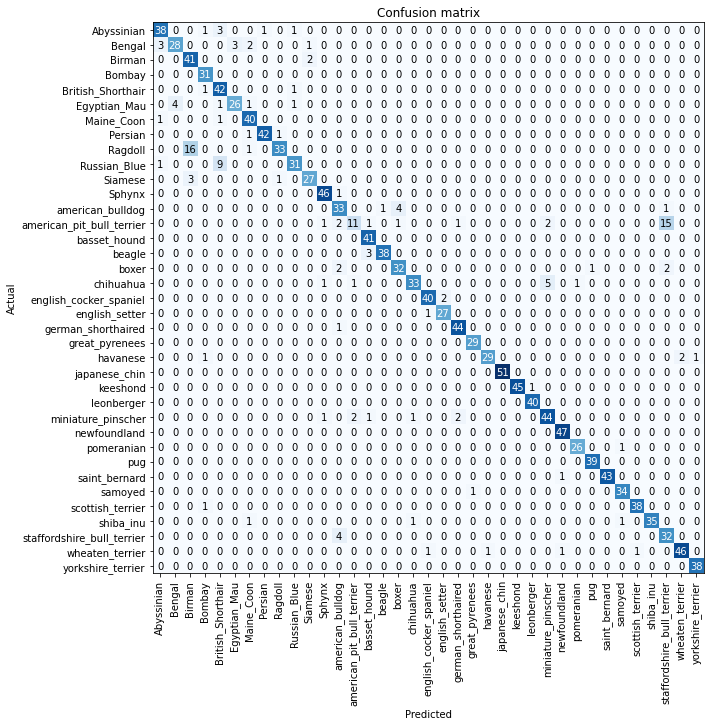

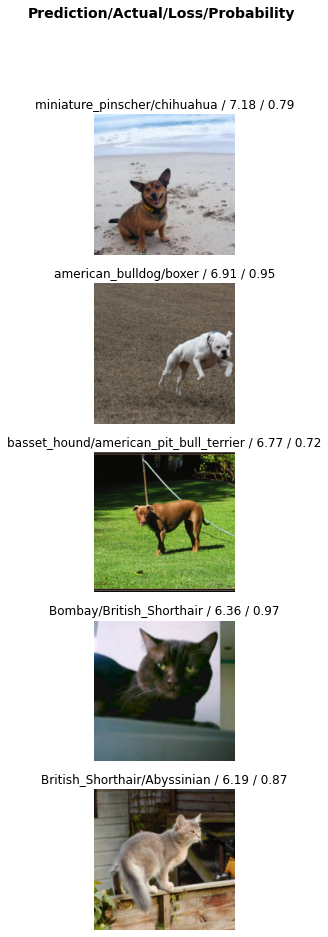

In [ ]:
# Let's take a look at the confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))

interp.plot_top_losses(5, nrows=5)

In [ ]:
# Clean dataset (crashes notebook b/c dataset is too large)
# from fastai.vision.widgets import * # I HATE THE FASTAI IMPORT 
# cleaner = ImageClassifierCleaner(learn)
# cleaner

In [ ]:
# Apply Cleaning
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
#for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## **DataBlock API**
```
DataBlock(blocks=None,
           dl_type=None,
           getters=None,
           n_inp=None,
           item_tfms=None,  # Item Transform 
           batch_tfms=None, # Batch Transform
           get_items=None,
           splitter=None,
           get_y=None,
           get_x=None)
```

Data Augmentation:
[https://docs.fast.ai/vision.augment.html#aug_transforms](https://docs.fast.ai/vision.augment.html#aug_transforms)

**item_tfms:**
- item_tfms:
  - item_tfms=resize(128) # Default grab from center of image
  - item_tfms=resize(128, ResizeMethod.Squish) # Squish image
  - item_tfms=resize(128, ResizeMethod.Pad, pad_mode="zeros") # Padding image
  - item_tfms=RandomResizedCrop(128, min_scale=0.3) 
- batch_tfms:
  - batch_tfms=aug_transforms(mult=2)

```
def aug_transforms(mult=1.0, do_flip=True, flip_vert=False, max_rotate=10., min_zoom=1., max_zoom=1.1,
                   max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75, xtra_tfms=None, size=None,
                   mode='bilinear', pad_mode=PadMode.Reflection, align_corners=True, batch=False, min_scale=1.):
```


Other Transforms:
```

__all__ = ['RandTransform', 'TensorTypes', 'FlipItem', 'DihedralItem', 'PadMode', 'CropPad', 'RandomCrop',
           'OldRandomCrop', 'ResizeMethod', 'Resize', 'RandomResizedCrop', 'AffineCoordTfm', 'RandomResizedCropGPU',
           'affine_mat', 'mask_tensor', 'flip_mat', 'Flip', 'DeterministicDraw', 'DeterministicFlip', 'dihedral_mat',
           'Dihedral', 'DeterministicDihedral', 'rotate_mat', 'Rotate', 'zoom_mat', 'Zoom', 'find_coeffs',
           'apply_perspective', 'Warp', 'LightingTfm', 'Brightness', 'Contrast', 'cutout_gaussian', 'norm_apply_denorm',
           'RandomErasing', 'setup_aug_tfms', 'aug_transforms']
```
